In [1]:
import pandas as pd

In [2]:
import pandas as pd

DATASET_PATH = "Truth_Seeker_Model_Dataset.csv"
df = pd.read_csv(DATASET_PATH)

# Displays the total number of rows (sentences) in the dataset.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data. 
# Shuffles the rows in the dataset randomly to ensure randomness in training and testing splits.
# frac=1 ensures all rows are included in the shuffled DataFrame.
df = df.sample(frac=1)

Number of training sentences: 134,198



In [3]:
# Combines the statement and tweet columns into a single string for each row.
# Example output: A formatted sentence string that concatenates the statement and a related tweet.
#sentences = 'Statement: ' + df['statement'] + '| Tweet: ' +df['tweet']

df['statement'] = df['statement'].fillna("No statement provided").str.strip()
df['tweet'] = df['tweet'].fillna("No tweet provided").str.strip()
sentences = 'Statement: ' + df['statement'] + ' || Tweet: ' + df['tweet']


In [4]:
sentences[0]

'Statement: End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic.| Tweet: @POTUS Biden Blunders - 6 Month Update\n\nInflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?'

In [5]:
# Extracts the binary target labels (True or False) for classification.
# labels will be used for training the model.
# labels = df["BinaryNumTarget"].values
assert set(df["BinaryNumTarget"].unique()).issubset({0, 1}), "Invalid labels detected!"
labels = df["BinaryNumTarget"].fillna(0).astype(int).values

### These functions determine the label (truthfulness) for each row based on the combination of the target value and the majority answer.
#### Logic for 4-way function:
Handles four categories of truthfulness: "True", "False", "Mostly True", "Mostly False".
The label is flipped if target is False (e.g., "Agree" becomes "False").
#### Logic for 2-way function:
Handles binary truthfulness: "True" or "False".
Simplifies the decision by considering only two categories of majority answers: "Agree" and "Disagree".
#### Conditionals: 
The nested if-elif structure ensures that each row is assigned exactly one label based on its characteristics.

In [6]:
def generate_truthfulness_4way(row):
    # Check if the 'target' column in the current row is True
    if row['target'] == True:
        if row['5_label_majority_answer'] == 'Agree':
            return "True"
        elif row['5_label_majority_answer'] == 'Disagree':
            return "False"
        elif row['5_label_majority_answer'] == 'Mostly Agree':
            return "Mostly True"
        elif row['5_label_majority_answer'] == 'Mostly Disagree':
            return "Mostly False"
    else:  # If the 'target' column is not True (i.e., False)
        if row['5_label_majority_answer'] == 'Agree':
            return "False"
        elif row['5_label_majority_answer'] == 'Disagree':
            return "True"
        elif row['5_label_majority_answer'] == 'Mostly Agree':
            return "Mostly False"
        elif row['5_label_majority_answer'] == 'Mostly Disagree':
            return "Mostly True"

def generate_truthfulness_2way(row):
    # Check if the 'target' column in the current row is True
    if row['target'] == True:
        if row['3_label_majority_answer'] == 'Agree':
            return "True"
        elif row['3_label_majority_answer'] == 'Disagree':
            return "False"
    else:  # If the 'target' column is not True (i.e., False)
        if row['3_label_majority_answer'] == 'Agree':
            return "False"
        elif row['3_label_majority_answer'] == 'Disagree':
            return "True"

### This step processes the data for classification tasks:
4-way classification for nuanced truthfulness.
2-way classification for simpler binary truthfulness.
These labels can then be used as target variables for training machine learning or deep learning models.

In [7]:
df2 = pd.DataFrame()
df2['4-way-label'] = df.apply(lambda x: generate_truthfulness_4way(x), axis=1)
df2['2-way-label'] = df.apply(lambda x: generate_truthfulness_2way(x), axis=1)

In [8]:
df2

,4-way-label,2-way-label
45641,Mostly True,True
73526,None,True
14530,Mostly True,True
18373,True,True
57568,False,False
...,...,...
44179,None,True
6790,True,True
31253,None,True
88296,False,False


In [12]:
# Replace the string labels ('True' and 'False') with numerical values (0 and 1), which are better suited for machine learning models.
df2 = df2[df2['2-way-label'].notnull()]
df2['2-way-label'] = df2['2-way-label'].replace({'True': 0, 'False': 1})

In [13]:
df2

,4-way-label,2-way-label
45641,Mostly True,0
73526,None,0
14530,Mostly True,0
18373,True,0
57568,False,1
...,...,...
44179,None,0
6790,True,0
31253,None,0
88296,False,1


        4-way-label  2-way-label
45641   Mostly True            0
73526          None            0
14530   Mostly True            0
18373          True            0
57568         False            1
...             ...          ...
44179          None            0
6790           True            0
31253          None            0
88296         False            1
50706  Mostly False            1

[134198 rows x 2 columns]


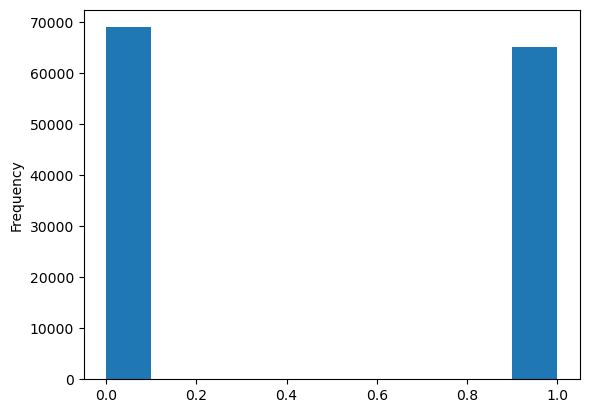

In [14]:
# Creates a histogram to visualize the distribution of the values in the 2-way-label column.
df2['2-way-label'].plot(kind='hist')
print(df2)

In [15]:
# Takes the numerical values (0 and 1) from the 2-way-label column in df2 and converts them into a NumPy array using the .values attribute.
labels = df2['2-way-label'].values
labels

array([0, 0, 0, ..., 0, 1, 1])

### Loads a pre-trained BERT tokenizer from the Hugging Face model hub.
'bert-base-uncased' specifies the version of the tokenizer:
bert-base: A smaller, general-purpose BERT model with ~110 million parameters.
uncased: The tokenizer will convert all text to lowercase and ignore case distinctions.

#### The tokenizer converts input text into tokens (subword units) and maps them to integer IDs based on the BERT vocabulary.

In [16]:
#!pip install transformers

In [17]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [18]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Statement: End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic. || Tweet: @POTUS Biden Blunders - 6 Month Update

Inflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?
Tokenized:  ['statement', ':', 'end', 'of', 'ev', '##iction', 'mora', '##torium', 'means', 'millions', 'of', 'americans', 'could', 'lose', 'their', 'housing', 'in', 'the', 'middle', 'of', 'a', 'pan', '##de', '##mic', '.', '|', '|', 't', '##wee', '##t', ':', '@', 'pot', '##us', 'bid', '##en', 'blu', '##nder', '##s', '-', '6', 'month', 'update', 'inflation', ',', 'delta', 'mis', '##mana', '##gement', ',', 'co', '##vid', 'for', 'kids', ',', 'abandoning', 'americans', 'in', 'afghanistan', ',', 'arm', '##ing', 'the', 'taliban', ',', 's', '.', 'border', 'crisis', ',', '

#### Tokenization: Converts text into a form BERT can process.
#### Numerical Mapping: Prepares the data for computation inside the model.
#### Understanding: Lets you see exactly how the raw sentence transforms into something the model understands.
    
### Position in the Sequence:
#### [CLS] is always at the start (index 0).
##### [SEP] marks the end of a sentence or separates two sentences.
### Processing:
When BERT processes the input, it assigns special meanings to these tokens:
#### The [CLS] token gathers the information from the entire sequence for classification tasks.
#### The [SEP] token helps differentiate between sentence segments, improving context understanding.

In [19]:
max_len = 0
from tqdm import tqdm

# For every sentence...
for sent in tqdm(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

100%|███████████████████████████████████████████████████| 134198/134198 [01:14<00:00, 1806.62it/s]

Max sentence length:  407


### This step is foundational for using BERT because it:

#### Prepares the data in a numerical, model-compatible format.
#### Ensures consistent input length.
#### Incorporates special tokens for proper processing by BERT.
#### Provides attention masks to focus the model on meaningful parts of the data.
Without this preprocessing step, the BERT model would not be able to understand or process your data effectively.

In [20]:
#!pip install torch
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu124
CUDA available: True


In [22]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example sentence
text = "Test sentence for PyTorch tensor"

encoded_dict = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=10,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',  # Ensure PyTorch tensors are requested
)

print(encoded_dict['input_ids'].device)  # Should print 'cpu' or 'cuda:0'


cpu


In [23]:
from tqdm import tqdm
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
MAX_SENTENCE_LENGTH = 410

# For every sentence...
for sent in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_SENTENCE_LENGTH,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                       
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])



100%|███████████████████████████████████████████████████| 134198/134198 [01:43<00:00, 1302.31it/s]


### PyTorch models expect tensors as inputs. Converting your data into tensors makes it compatible with the model.
#### input_ids: A 2D tensor of shape (num_sentences, MAX_SENTENCE_LENGTH) representing tokenized and padded sentences.
#### attention_masks: A 2D tensor of the same shape, indicating which tokens are real and which are padding.
#### labels: A 1D tensor of shape (num_sentences,) containing binary classification labels.
#### This step ensures that all your preprocessed data is ready for use in a PyTorch-based BERT model.

In [26]:
import torch
# Convert the lists into tensors.


# Ensure input_ids is a list of tensors
if not isinstance(input_ids, torch.Tensor):  # Check if input_ids is not already a tensor
    input_ids = [torch.tensor(ids, dtype=torch.long) for ids in input_ids]  # Convert to tensor list
    input_ids = torch.cat(input_ids, dim=0)  # Concatenate tensors along dimension 0

# Ensure attention_masks is a list of tensors
if not isinstance(attention_masks, torch.Tensor):  # Check if attention_masks is not already a tensor
    attention_masks = [torch.tensor(mask, dtype=torch.float) for mask in attention_masks]  # Convert to tensor list
    attention_masks = torch.cat(attention_masks, dim=0)  # Concatenate tensors along dimension 0

# Ensure labels is a tensor with the correct dtype
if not isinstance(labels, torch.Tensor):  # Check if labels is not already a tensor
    labels = torch.tensor(labels, dtype=torch.long)  # Convert to tensor

In [30]:
# Inspects the preprocessed data to ensure that the 
# tokenization and label preparation steps were done correctly. 
index = 10
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[index])
print('Token IDs:', input_ids[index])
print ('Labels:', labels[index])

Original:  Statement: End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic. || Tweet: BREAKING NEWS: Mitch McConnell accuses President Biden of pushing socialism by implementing the eviction moratorium that will stop millions of Americans from being thrown out on the street this month. RT if you think that Mitch is a heartless idiot!
Token IDs: tensor([  101,  4861,  1024,  1996,  2616,  1000,  4942, 28600,  2319, 12256,
        17603,  2140,  1010,  1000,  2029,  6945, 16371, 11461,  2170,  2343,
        13857,  8112,  1010,  2020,  2109,  2011,  1996, 13157,  2000,  1000,
        16114,  1996, 14052,  1997,  1996,  3644,  2451,  1012,  1000,  1064,
         1064,  1056, 28394,  2102,  1024,  6945, 16371, 11461, 16360,  5339,
        18718,  9706,  4747,  5856,  4371,  1018,  2655,  3653,  2015,  8112,
         1000,  4942, 28600,  2319, 12256, 17603,  2140,  1010,  1000, 19067,
         1037,  1012,  1043,  1012,  6754, 14455,  2

In [31]:
print(input_ids.shape)

torch.Size([134198, 410])


### This code creates a TensorDataset to combine your inputs (input_ids, attention_masks, and labels) into a single dataset and then splits it into training and validation sets with an 80-20 ratio.
#### Prepares Data for Training:
Organizes the input IDs, attention masks, and labels into a single structure (TensorDataset) for easy handling.
#### Ensures Data Splitting:

Divides the dataset into training and validation sets to evaluate the model's performance during training.
#### Supports Random Sampling:

random_split ensures the split is randomized, which is essential to avoid biases in training or validation.

In [33]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)  # Set the random seed
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

107,358 training samples
26,840 validation samples


#### This code creates DataLoaders for the training and validation datasets to efficiently handle and feed data to the BERT model during training and evaluation. The DataLoaders manage batching, sampling, and shuffling of data.

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Create the DataLoader for the validation set
validation_dataloader = DataLoader(
    val_dataset,                     # The validation dataset
    sampler=SequentialSampler(val_dataset),  # Sequential sampling for consistent evaluation
    batch_size=batch_size            # Number of samples per batch
)

#### This code initializes a BERT model for a binary classification task, preparing it for fine-tuning on your dataset. It loads the pre-trained BERT model with a classification head (a linear layer) on top and specifies configurations for the model's behavior and output.

In [35]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### This code inspects and prints the parameters of the BERT model. It provides insights into the structure and dimensions of the model's parameters, including the embedding layer, transformer layers, and the classification head (output layer).

In [26]:
#not used!pip install torch==2.5.1 torchvision transformers==4.46.0

In [37]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#### This code sets up an optimizer for training your BERT model. Specifically, it uses the AdamW optimizer, which is recommended for fine-tuning transformer models like BERT.

In [40]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

#### This code sets up a learning rate scheduler to adjust the learning rate during training. Specifically, it uses a linear schedule with a warmup phase, which is recommended for fine-tuning transformer models like BERT.

In [41]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

#### This code defines a function, flat_accuracy, to calculate the accuracy of predictions compared to the true labels during model evaluation.

In [42]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#### This code defines a utility function format_time that converts a time duration (in seconds) into a more human-readable string format (hh:mm:ss).

In [43]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: NVIDIA RTX 6000 Ada Generation


In [45]:
#######  changed from /p2/data -> p2/data
SAVE_DIR = 'p2/data/checkpoints/checkpoint_with_maxlength_410'

### This code is the training and validation loop for fine-tuning a BERT model on your dataset. It performs the following:

#### Trains the model over several epochs.
#### Evaluates the model on a validation set after each epoch.
#### Tracks key metrics such as training/validation loss, validation accuracy, and timing.
#### Saves the model's weights (checkpoints) after each epoch.

In [47]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    train_loss = 0
    total_fake_examples = 0
    total_true_examples = 0
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        if step > 8000:
            break
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}. Training loss. {:} Num fake examples {:} Num true examples {:}'.format(step, len(train_dataloader), elapsed, train_loss,total_fake_examples, total_true_examples ))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(torch.int64).to(device)
        total_fake_examples += (b_labels == 1).sum().item()
        total_true_examples += (b_labels == 0).sum().item()
        #print (f"{b_labels.shape=}")
        b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).float()
        #print (b_input_ids.shape, b_labels.shape, b_input_mask.shape, b_labels_one_hot.shape, b_labels_one_hot.dtype)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels_one_hot)
        loss = output.loss
        logits = output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        train_loss= loss.item()
        total_train_loss += train_loss

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        #print (f"Training loss", loss.item())

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    for step, batch in enumerate(validation_dataloader):
        if step > 8000:
            break
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(torch.int64).to(device)
        b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).float()
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels_one_hot)
            loss = output.loss
            logits = output.logits


            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    #Save model checkpoint
    model.save_pretrained(SAVE_DIR)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  3,355.    Elapsed: 0:00:13. Training loss. 0.05325314402580261 Num fake examples 637 Num true examples 643
  Batch    80  of  3,355.    Elapsed: 0:00:27. Training loss. 0.04623487591743469 Num fake examples 1263 Num true examples 1297
  Batch   120  of  3,355.    Elapsed: 0:00:41. Training loss. 0.045033201575279236 Num fake examples 1903 Num true examples 1937
  Batch   160  of  3,355.    Elapsed: 0:00:56. Training loss. 0.34403926134109497 Num fake examples 2472 Num true examples 2648
  Batch   200  of  3,355.    Elapsed: 0:01:10. Training loss. 0.4330782890319824 Num fake examples 3089 Num true examples 3311
  Batch   240  of  3,355.    Elapsed: 0:01:25. Training loss. 0.1362992227077484 Num fake examples 3702 Num true examples 3978
  Batch   280  of  3,355.    Elapsed: 0:01:39. Training loss. 0.34318041801452637 Num fake examples 4338 Num true examples 4622
  Batch   320  of  3,355.    Elapsed: 0:01:54. Training loss. 0.

## Inference

#### This code encodes a single sentence, passes it through the fine-tuned BERT model in evaluation mode, and prints the model's output along with the true label for that sentence. The purpose is to test the model on a specific input sentence and examine its predictions.

In [36]:
def encode(sentence):
    return tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 410,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

SENTENCE_INDEX = 5000
encoded_dict = encode(sentences[SENTENCE_INDEX])
input_id = encoded_dict['input_ids']
attention_mask = encoded_dict['attention_mask']
print (input_id.shape)
model.eval()
output = model(
            input_id.cuda(),
            token_type_ids=None, 
            attention_mask=attention_mask.cuda(), return_dict=True)
print (output)
print (labels[SENTENCE_INDEX])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([1, 410])
SequenceClassifierOutput(loss=None, logits=tensor([[ 5.4051, -5.4143]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor(0)


/home/grace/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Using validation dataset

In [37]:
val_dataset[0][1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [38]:

SENTENCE_INDEX = 5000
model.eval()
print (torch.unsqueeze(val_dataset[SENTENCE_INDEX][0].cuda(), dim=0).shape)
output = model(torch.unsqueeze(val_dataset[SENTENCE_INDEX][0].cuda(), dim=0),
            token_type_ids=None, 
            attention_mask=torch.unsqueeze(val_dataset[SENTENCE_INDEX][0].cuda(),dim=0), return_dict=True)
print (output)
print (labels[SENTENCE_INDEX])

torch.Size([1, 410])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.6035, -0.5707]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor(0)


In [39]:
for step, batch in enumerate(validation_dataloader):
    if step > 5:
        break
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(torch.int64).to(device)
    b_labels_one_hot = torch.nn.functional.one_hot(b_labels, num_classes=2).float()
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        
        output = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels_one_hot)
        loss = output.loss
        logits = output.logits
        print (logits, b_labels)

tensor([[ 5.3777, -5.3881],
        [ 5.3652, -5.3792]], device='cuda:0') tensor([0, 0], device='cuda:0')
tensor([[ 5.0588, -5.0063],
        [ 5.3725, -5.4029]], device='cuda:0') tensor([0, 0], device='cuda:0')
tensor([[-5.3577,  5.3462],
        [-5.3761,  5.3724]], device='cuda:0') tensor([0, 1], device='cuda:0')
tensor([[ 5.4580, -5.4627],
        [ 5.4304, -5.4484]], device='cuda:0') tensor([0, 0], device='cuda:0')
tensor([[-5.3407,  5.3387],
        [ 4.5246, -4.5115]], device='cuda:0') tensor([1, 0], device='cuda:0')
tensor([[-5.3731,  5.3666],
        [-5.3586,  5.3509]], device='cuda:0') tensor([1, 1], device='cuda:0')
